# Autoencoder Training Notebook
This notebook creates and trains the autoencoder used later on in the classifier pipeline. There are several helper functions in this notebook each commented to indicate its function.

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import pandas as pd
from scipy import signal

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch

from tqdm import tqdm
from sklearn.model_selection import train_test_split

## Load dataset
The data should already normalized and aligned with the stress labels in a csv format. These functions below split the data into train, test and validation splits and optionally apply a low pass filter to the EEG inputs.

In [3]:
def split_filtered_and_raw(filtered_data : list, raw_data : list, random_seed=128) -> list:
    '''
    Function to take in an entire unsplit dataset (no filter applied and filtered) and create splits for training, validating and testing for the
    both the classifier and autoencoder training tasks 
    '''
    
    autoencoder_split, classifier_split = train_test_split(filtered_data, test_size=0.7, random_state=random_seed, shuffle=True)
    autoencoder_split_raw, classifier_split_raw = train_test_split(raw_data, test_size=0.7, random_state=random_seed, shuffle=True)
    
    # split data into train and test
    autoencoder_train, autoencoder_test = train_test_split(np.array(autoencoder_split), test_size=0.2, random_state=random_seed, shuffle=True)
    autoencoder_train_raw, autoencoder_test_raw = train_test_split(np.array(autoencoder_split_raw), test_size=0.2, random_state=random_seed, shuffle=True)
    
    classifier_train, classifier_test = train_test_split(np.array(classifier_split), test_size=0.2, random_state=random_seed, shuffle=True)
    classifier_train_raw, classifier_test_raw = train_test_split(np.array(classifier_split_raw), test_size=0.2, random_state=random_seed, shuffle=True)

    
    # further split train into validation and train
    autoencoder_train, autoencoder_val = train_test_split(autoencoder_train, test_size=0.2, random_state=random_seed, shuffle=True)
    autoencoder_train_raw, autoencoder_val_raw = train_test_split(autoencoder_train_raw, test_size=0.2, random_state=random_seed, shuffle=True)
    
    classifier_train, classifier_val = train_test_split(classifier_train, test_size=0.2, random_state=random_seed, shuffle=True)
    classifier_train_raw, classifier_val_raw = train_test_split(classifier_train_raw, test_size=0.2, random_state=random_seed, shuffle=True)
    
    
    split_dataset = [autoencoder_train, autoencoder_val, autoencoder_test, autoencoder_train_raw, autoencoder_val_raw, autoencoder_test_raw,
                     classifier_train, classifier_val, classifier_test, classifier_train_raw, classifier_val_raw, classifier_test_raw]
    return split_dataset
    

def load_and_split_dataset(eeg_ft_dir = 'ALIGNED_DATA', split_size=100, cutoff_lf=4, random_seed=128, num_subjects = 5, subject_choice_seed=128):
    '''
    Function to load and split the dataset from the given directory containing all the csv data
    '''
    subject_data_files = glob.glob(os.path.join(eeg_ft_dir, '*.csv'))
    # sort the files by the index given to them
    file_name_2_index = lambda file : int(file.split('.')[0].split('_')[-1])
    subject_data_files.sort() # sort alphabetically
    subject_data_files.sort(key=file_name_2_index) # sort by index
    # group data, pick num_subjects randomly
    np.random.seed(subject_choice_seed)
    all_eeg_ft_names = np.random.choice(subject_data_files, size=num_subjects, replace=False)
    print(f"Chosen subjects: {all_eeg_ft_names}")
    
    
    if cutoff_lf is not None:
        sos = signal.butter(10, cutoff_lf, 'lp', fs=1000, output='sos') # low pass filter
    
    
    full_dataset = []
    for x in all_eeg_ft_names:        
        dataset = []
        unfiltered = []
        
        # read the csv containing the EEG and Labels for a single subject
        input_label_pair = pd.read_csv(x).values
        input_label_pair_unfiltered = input_label_pair.copy()
        
        # apply the low pass filter
        if cutoff_lf is not None:
            input_label_pair[:,2:] = signal.sosfiltfilt(sos, input_label_pair[:,2:], axis=0)
        
        n_chunks = len(input_label_pair)/split_size
        
        split_data = np.array_split(input_label_pair, n_chunks)[:-1].copy()
        split_data_unfiltered = np.array_split(input_label_pair_unfiltered, n_chunks)[:-1].copy()
        
        del input_label_pair_unfiltered
        del input_label_pair
        
        for x_split, y_split in zip(split_data, split_data_unfiltered):
                if len(x_split) >= split_size:
                    dataset.append(x_split[:split_size].copy())
                    unfiltered.append(y_split[:split_size].copy())
                    
        split_dataset = split_filtered_and_raw(dataset, unfiltered, random_seed) # split data into train, validation and test sets
        
        full_dataset.append(split_dataset)
    return convert_loaded_dataset(full_dataset)

def convert_loaded_dataset(full_dataset):
    '''
    convert the full list into individual numpy arrays
    '''
    return [np.vstack([x[i] for x in full_dataset]) for i in range(12) ]

In [15]:
dataset = load_and_split_dataset(eeg_ft_dir = 'ALIGNED_DATA', split_size=100, cutoff_lf=None, random_seed=128, num_subjects = 5, subject_choice_seed=55)

'''
Obtain the raw and filtered datasets
'''
autoencoder_train, autoencoder_val, autoencoder_test = dataset[:3]
autoencoder_train_raw, autoencoder_val_raw, autoencoder_test_raw = dataset[3:6]

Chosen subjects: ['ALIGNED_DATA/EEG_FT_ALIGNED_9.csv' 'ALIGNED_DATA/EEG_FT_ALIGNED_2.csv'
 'ALIGNED_DATA/EEG_FT_ALIGNED_12.csv' 'ALIGNED_DATA/EEG_FT_ALIGNED_14.csv'
 'ALIGNED_DATA/EEG_FT_ALIGNED_4.csv']


## Visualize Dataset
Visualize several channels of the test set. Each entry of the dataset contains the EEG data for a fixed time window from a single individual so every instance the model sees the data singal for a single individual. The plot below sorts the time windows and super imposes them on each other and is only really useful for visualizing a single individual.

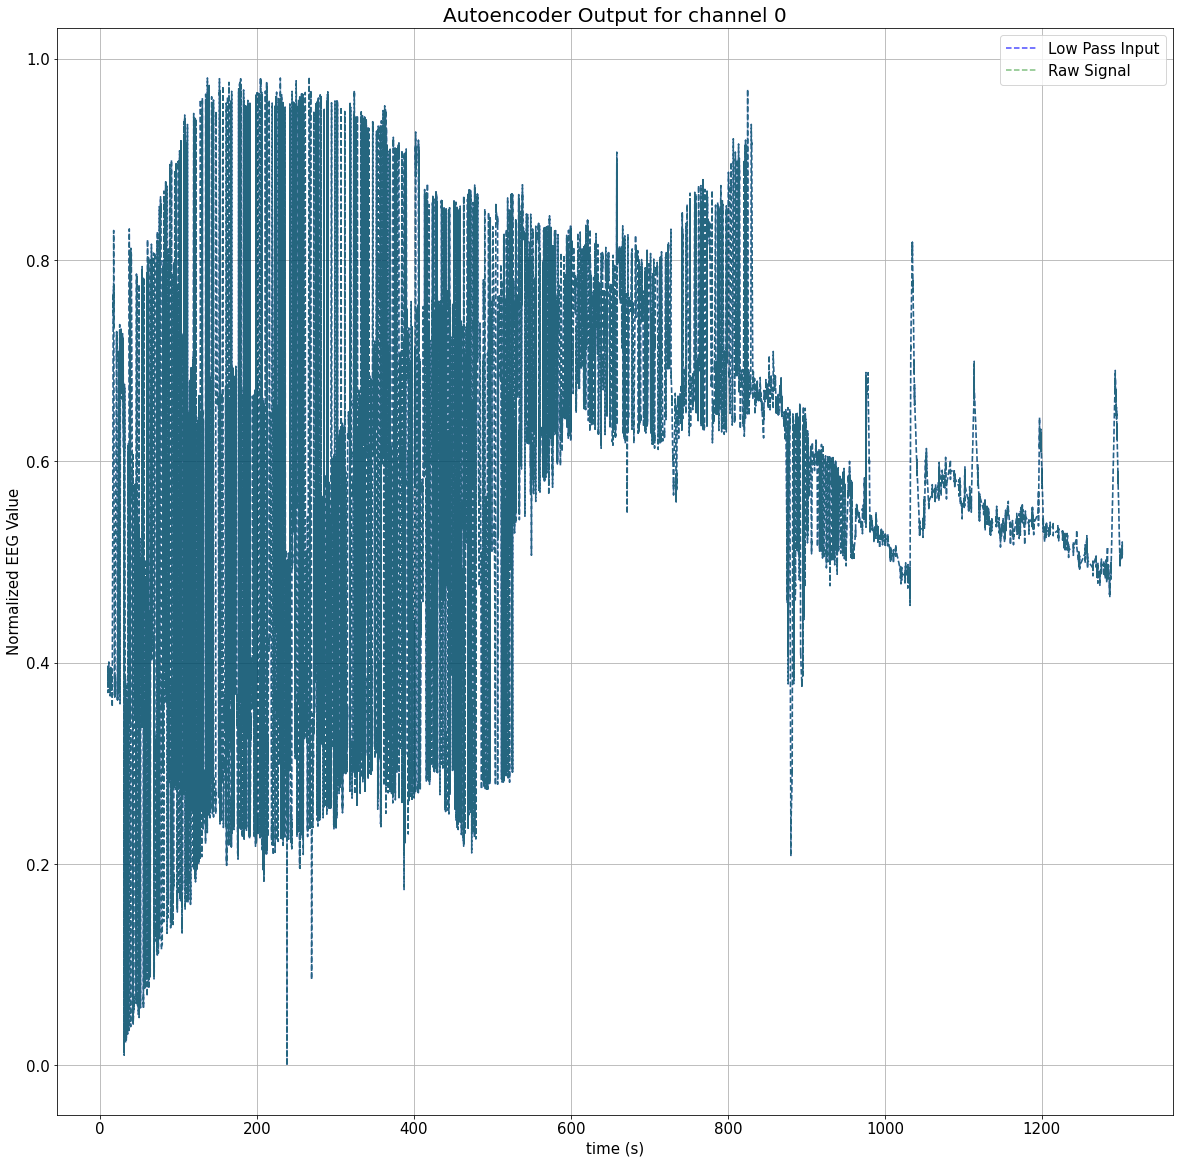

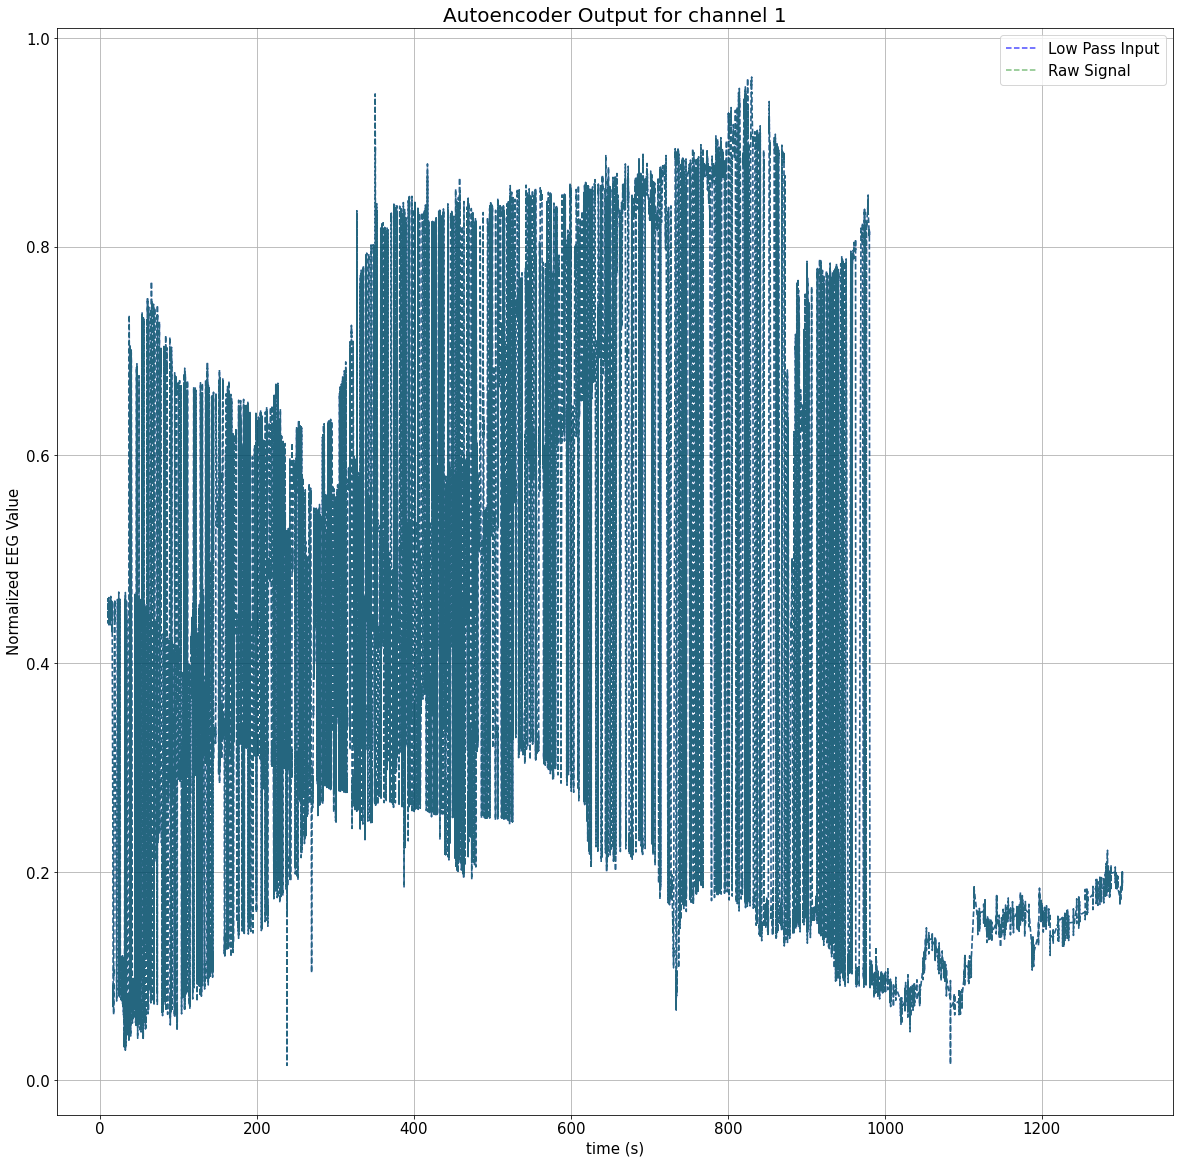

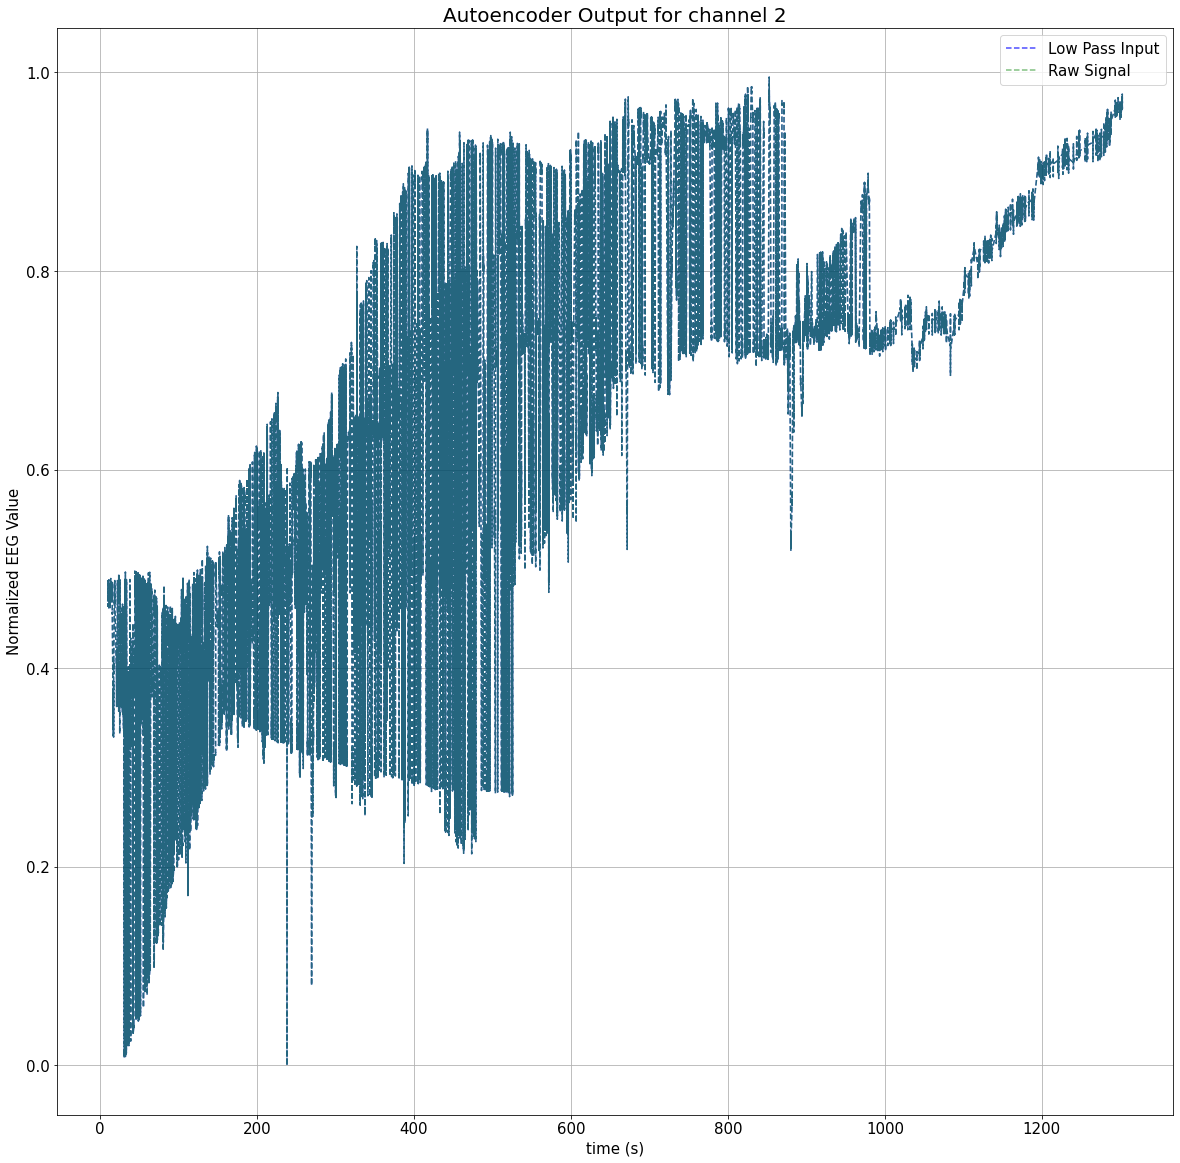

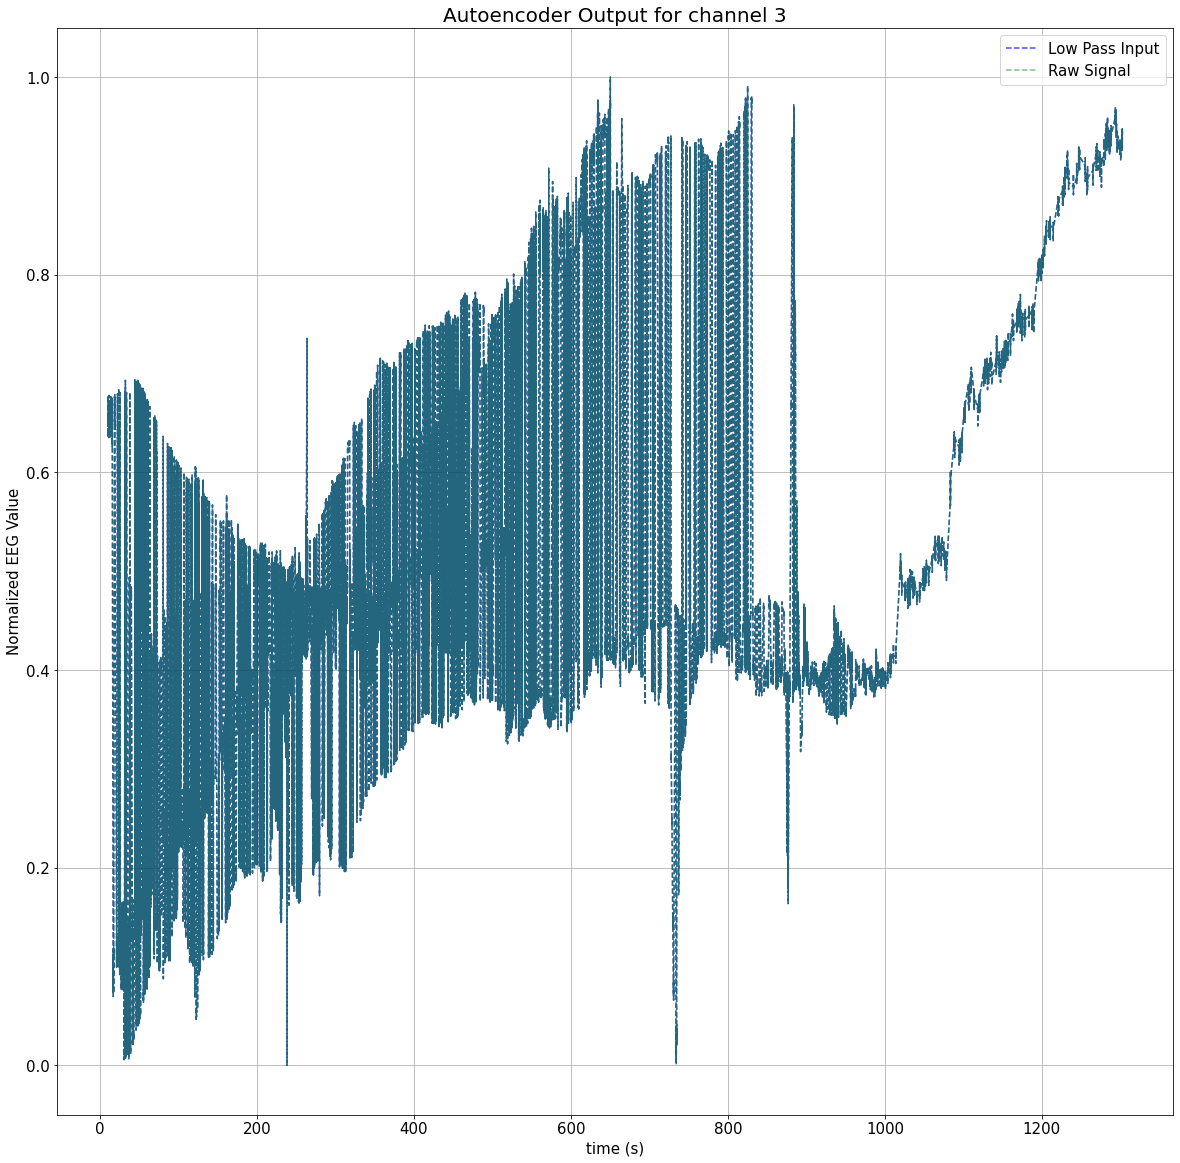

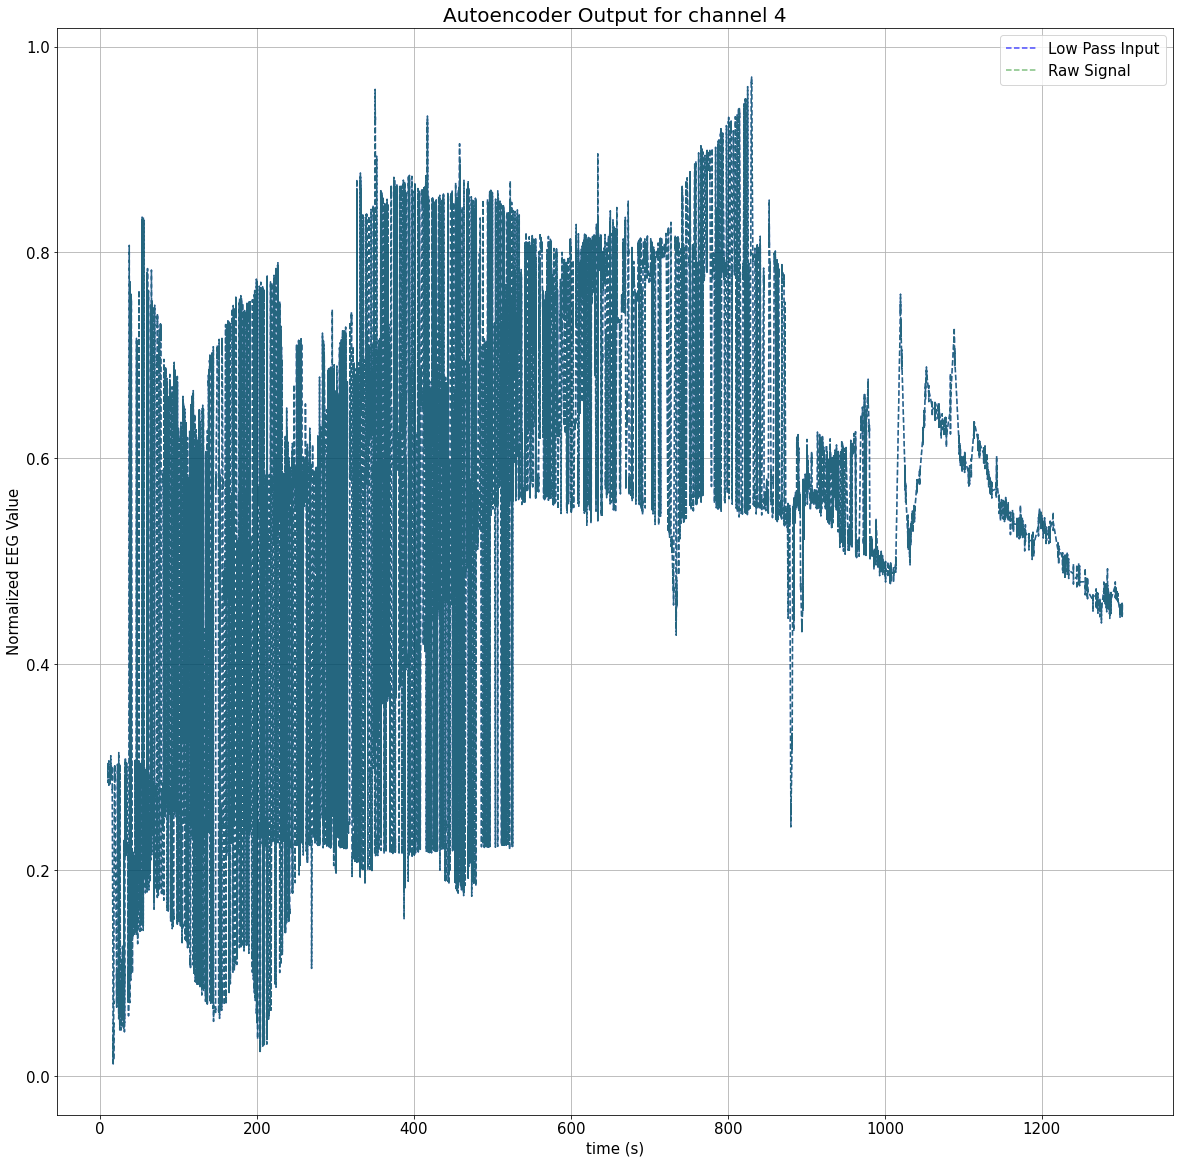

In [16]:
for data_index in range(5):
    t = autoencoder_test[:, :, 0].flatten()
    ind_t = np.argsort(t)
    t = t[ind_t]
        
    z_raw = autoencoder_test_raw[:, :, data_index+2].flatten()[ind_t]
    z = autoencoder_test[:, :, data_index+2].flatten()[ind_t]

    fig, axs = plt.subplots(figsize=(20,20))
    axs.tick_params(axis='both', which='major', labelsize=15)
    axs.grid(True)
    axs.set_title(f"Autoencoder Output for channel {data_index}", fontsize=20)
    axs.set_xlabel("time (s)", fontsize=15)
    axs.set_ylabel("Normalized EEG Value", fontsize=15)
        
    axs.plot(t, z, 'b--', alpha=0.7, label="Low Pass Input")
    axs.plot(t, z_raw, 'g--', alpha=0.5, label="Raw Signal")

    axs.legend(loc='best', fontsize=15)
    plt.show()

## Encoder Model
The following is the autoencoder model structure. The model is symmetric and is parameterized by three numbers, for example [32,8,32], the three numbers represent the number of features in the second layer, encoded features (latent space) and the number of features in the second last layer. The first and last layers contain 64 features which is the number of input channels from the EEG signal.

In [23]:
class autoencoder(nn.Module):
    def __init__(self, num_features=12):
        super(autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(True),
            nn.Dropout(p=0.0), # used for early experiments
            nn.Linear(32, num_features))
        self.decoder = nn.Sequential(
            nn.Linear(num_features, 32),
            nn.ReLU(True),
            nn.Linear(32, 64),
            nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def encode(self, x):
        x = self.encoder(x)
        return x
    
    def decode(self, x):
        x = self.decoder(x)
        return x

## Dataset Loader
the class below is used to prepare the data for training. Each instance consists of 64 values the correspond to a single (1 ms) sample of the EEG signal. Each sample is taken from a single subject.

In [24]:
class autoencoder_dataset(torch.utils.data.Dataset):
    def __init__(self, X):
        'Initialization'
        self.x = X[:, :, 2:] # only keep channel info
        self.x = self.x.reshape(-1, 64)

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.x)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        x = torch.from_numpy(self.x[index]).float()
        y = x

        return x, y

## Training Loop
The function below handles the training of the autoencoder model. The performance of the model is measured using the mean square error and the model is optimized using the adam optimizer with L2 regularization. The model is trained for a fixed number of epochs and then evaluated on the test data.

In [41]:
def train(model, num_epochs=5, batch_size=1, learning_rate=1e-3, train_split=autoencoder_train, test_split=autoencoder_val):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-8)

    criterion = nn.MSELoss()
    
    train_dataset = autoencoder_dataset(train_split)
    test_dataset = autoencoder_dataset(test_split)
        
    train_loader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=batch_size,
                                               num_workers=8,
                                               shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, 
                                               batch_size=batch_size,
                                               num_workers=8,
                                               shuffle=True)
    
    train_metrics = []
    test_metrics = []
    for epoch in range(num_epochs):
        
        # reset metrics
        cur_train_loss = 0 # loss
        
        # set to train mode
        model.train()
        
        # loop over dataset
        for data in tqdm(train_loader):
            x, y = data
            x = x.to(device)
            y = y.to(device)
            
            y_hat = model(x)
            loss = criterion(y_hat, y)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # metrics
            cur_train_loss += loss.detach().cpu()
            scheduler.step()
        
        # average metrics over loop
        train_loop_size = len(train_loader)
        cur_train_loss = cur_train_loss/train_loop_size
        
        
        train_metrics.append([cur_train_loss])
        
        with torch.no_grad():
            
            # reset metrics
            cur_test_loss = 0 # loss
            
            # set to evaluate mode, ignores dropout
            model.eval()
            
            # loop over dataset
            for data in tqdm(test_loader):
                x, y = data
                x = x.to(device)
                y = y.to(device)
                
                y_hat = model(x)
                loss = criterion(y_hat, y)
                
                # metrics
                cur_test_loss += loss.detach().cpu()
                
                
            # average metrics over loop
            test_loop_size = len(test_loader)
            cur_test_loss = cur_test_loss/test_loop_size
        
            test_metrics.append([cur_test_loss])
            
        print(f'Epoch:{epoch+1},'\
              f'\nTrain Loss:{cur_train_loss},'\
              f'\nTest Loss:{cur_test_loss},')
        
    return train_metrics, test_metrics

## Run Training
The training happens here

In [42]:
time_window=100 # 100ms, non - overlapping
num_features=4 # 64 channels for input features, eeg input


encoder_model = autoencoder(num_features=num_features)
n_epochs=10
train_metrics, test_metrics = train(encoder_model, n_epochs, batch_size=2048, learning_rate=1e-2, train_split=autoencoder_train, test_split=autoencoder_val)

100%|██████████| 98/98 [00:00<00:00, 136.63it/s]


Epoch:1,
Train Loss:0.007081771269440651,
Test Loss:0.0022441609762609005,


100%|██████████| 98/98 [00:00<00:00, 135.57it/s]


Epoch:2,
Train Loss:0.002146707382053137,
Test Loss:0.001934075029566884,


100%|██████████| 98/98 [00:00<00:00, 129.27it/s]


Epoch:3,
Train Loss:0.001961847534403205,
Test Loss:0.0018587971571832895,


100%|██████████| 98/98 [00:00<00:00, 135.98it/s]


Epoch:4,
Train Loss:0.0019167527789250016,
Test Loss:0.0018224300583824515,


100%|██████████| 98/98 [00:00<00:00, 138.69it/s]


Epoch:5,
Train Loss:0.0018946293275803328,
Test Loss:0.001813139533624053,


100%|██████████| 98/98 [00:00<00:00, 137.46it/s]


Epoch:6,
Train Loss:0.0018916602712124586,
Test Loss:0.001813444308936596,


100%|██████████| 98/98 [00:00<00:00, 136.14it/s]


Epoch:7,
Train Loss:0.001892859349027276,
Test Loss:0.001812926959246397,


100%|██████████| 98/98 [00:00<00:00, 135.00it/s]


Epoch:8,
Train Loss:0.0019173830514773726,
Test Loss:0.0018132561817765236,


100%|██████████| 98/98 [00:00<00:00, 127.33it/s]


Epoch:9,
Train Loss:0.0024693740997463465,
Test Loss:0.0018269105348736048,


100%|██████████| 98/98 [00:00<00:00, 132.69it/s]

Epoch:10,
Train Loss:0.0019387631909921765,
Test Loss:0.0021885461173951626,


#### Test on unseen data

In [19]:
#model_path = "1_subjects_seed_55_encoder_8_feat_raw.pth"
#torch.save(encoder_model.state_dict(), model_path)

Test MSE: 0.004386656693381623


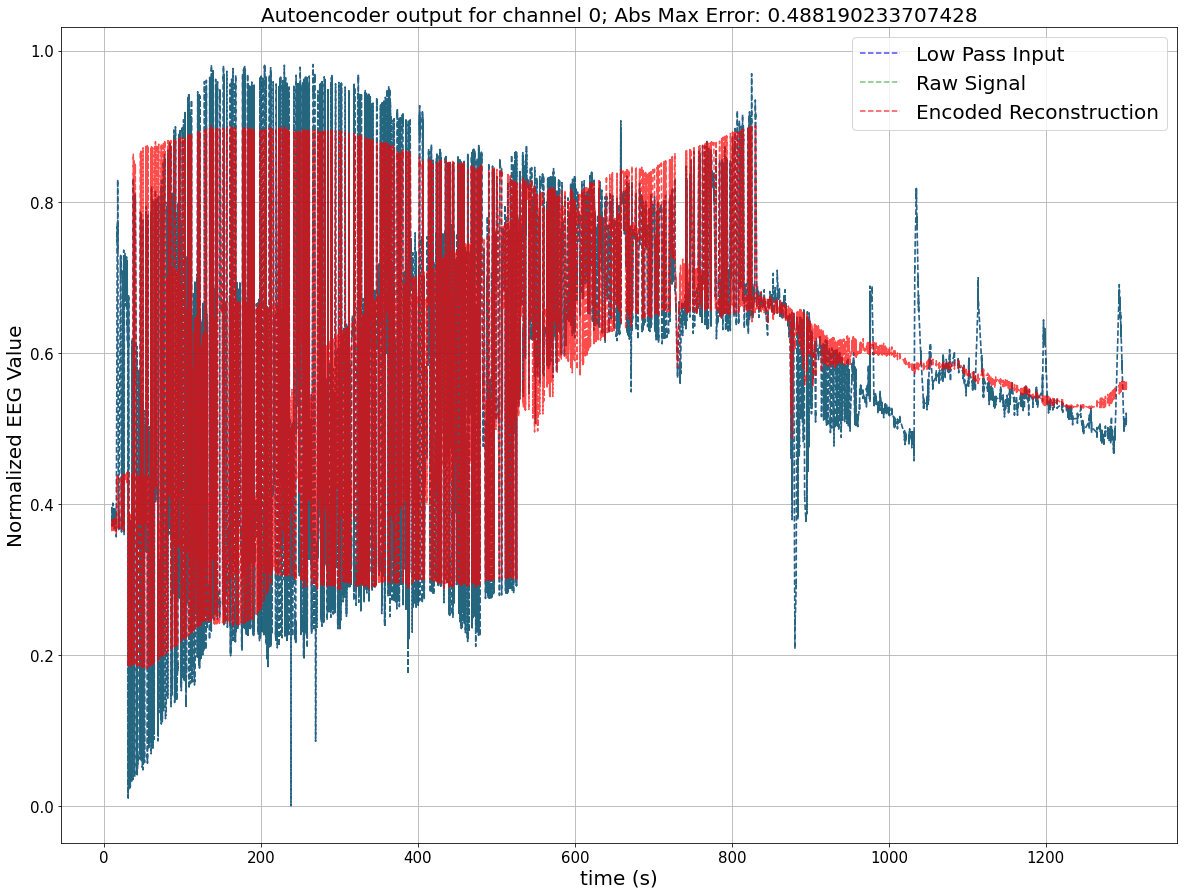

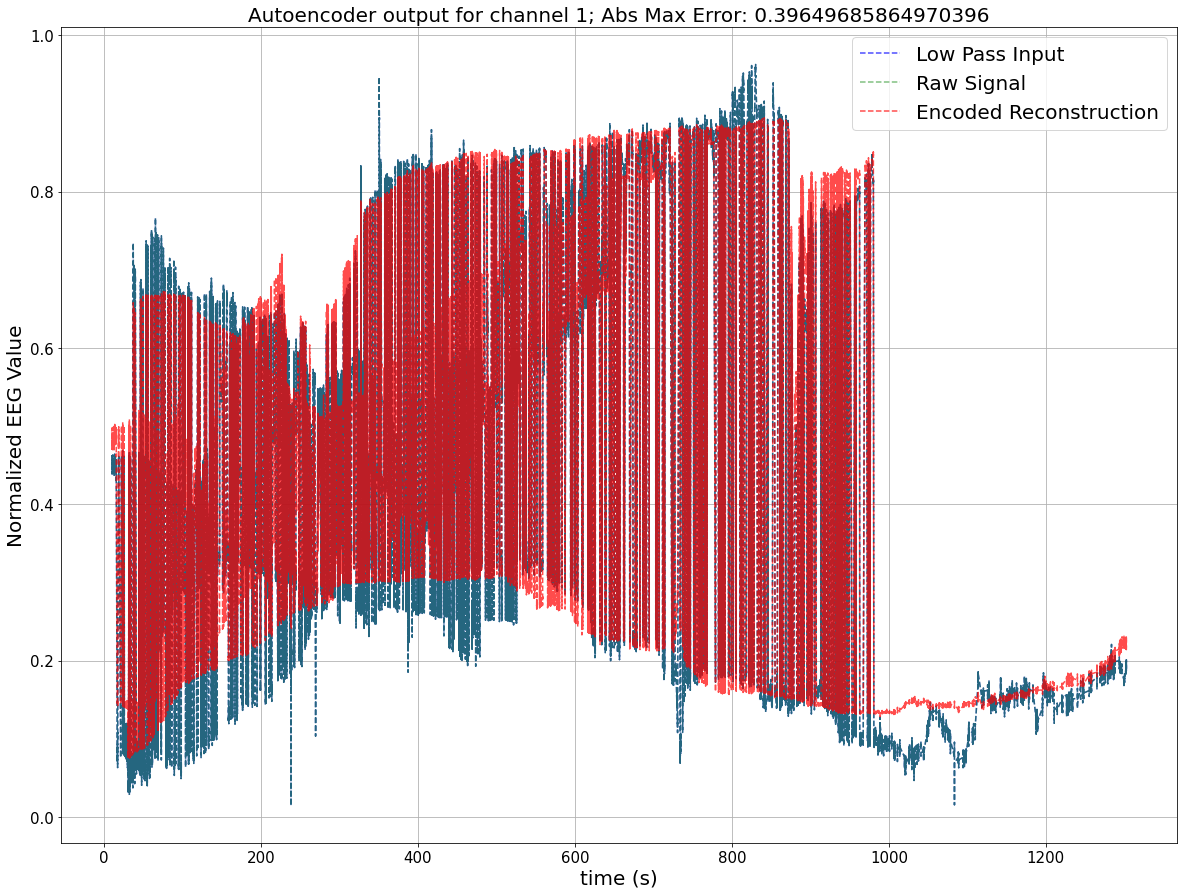

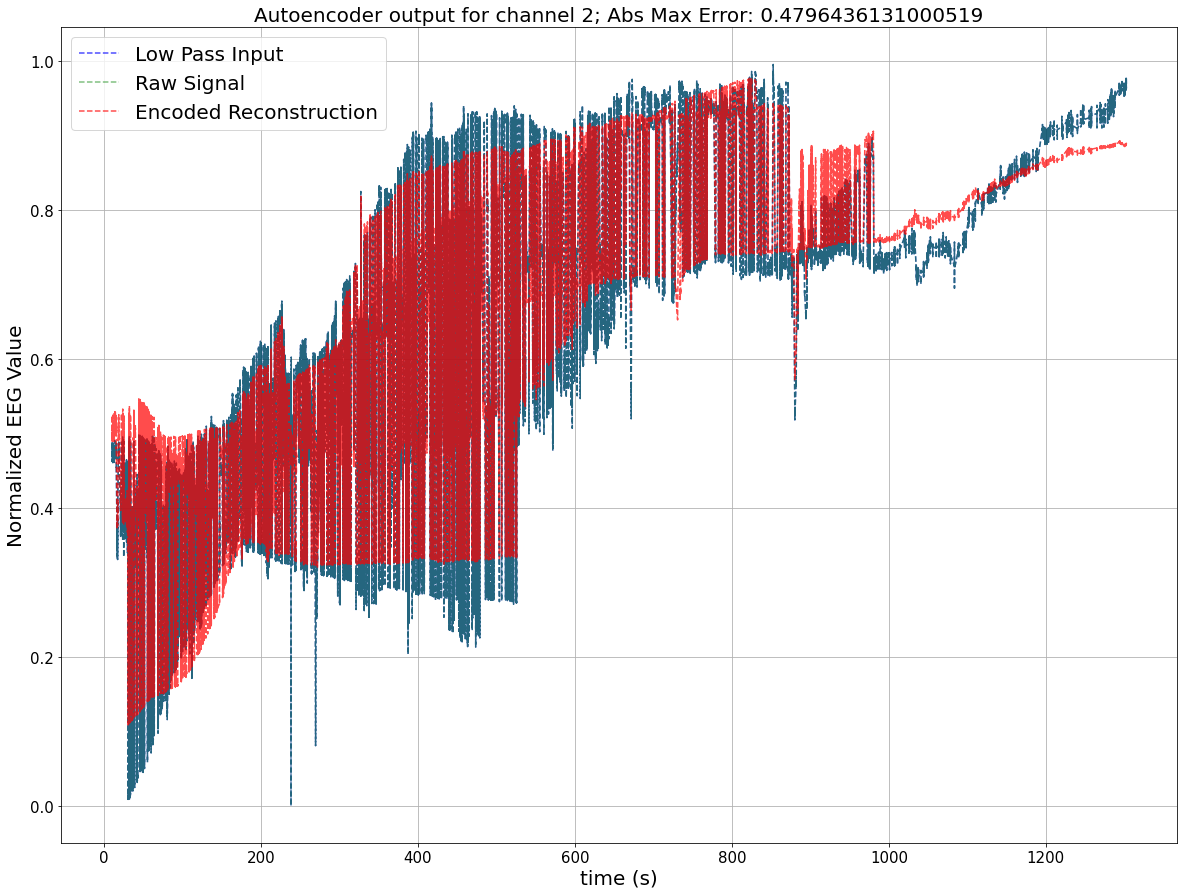

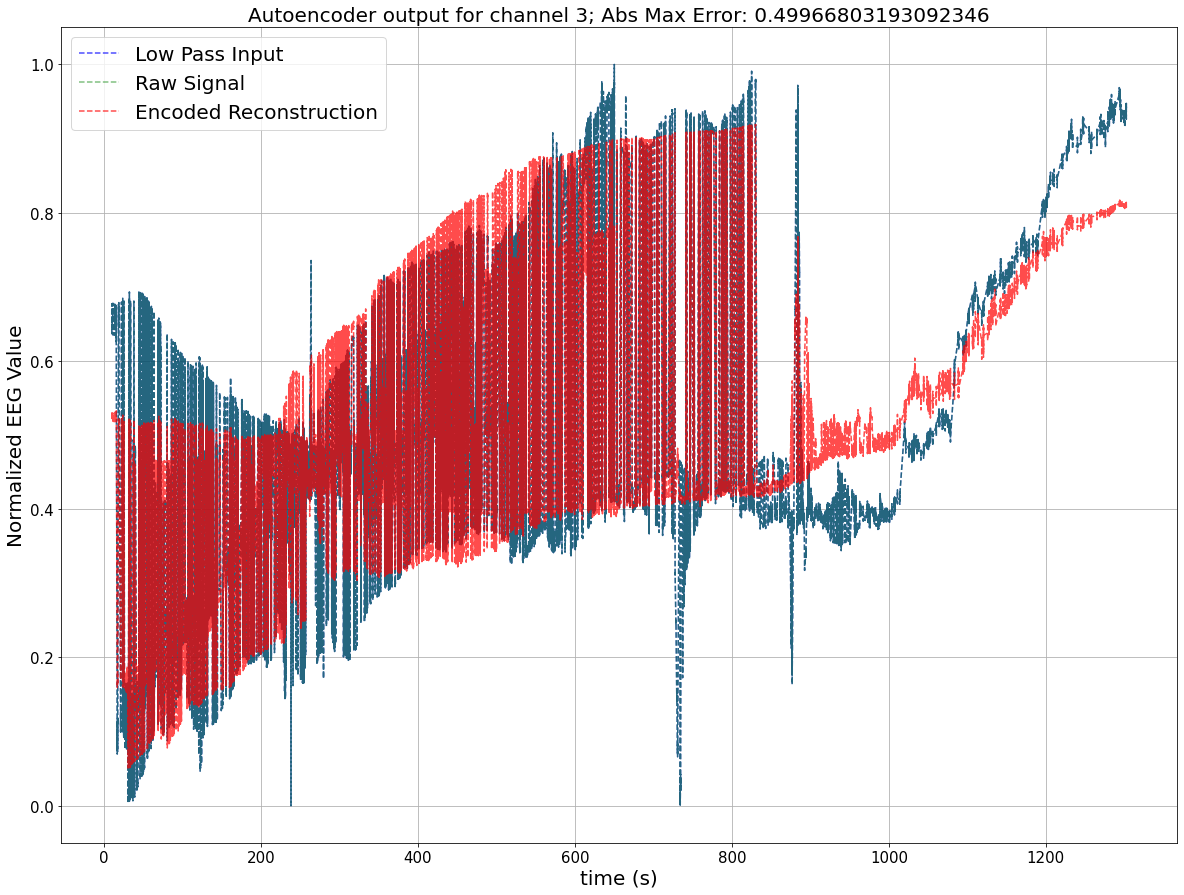

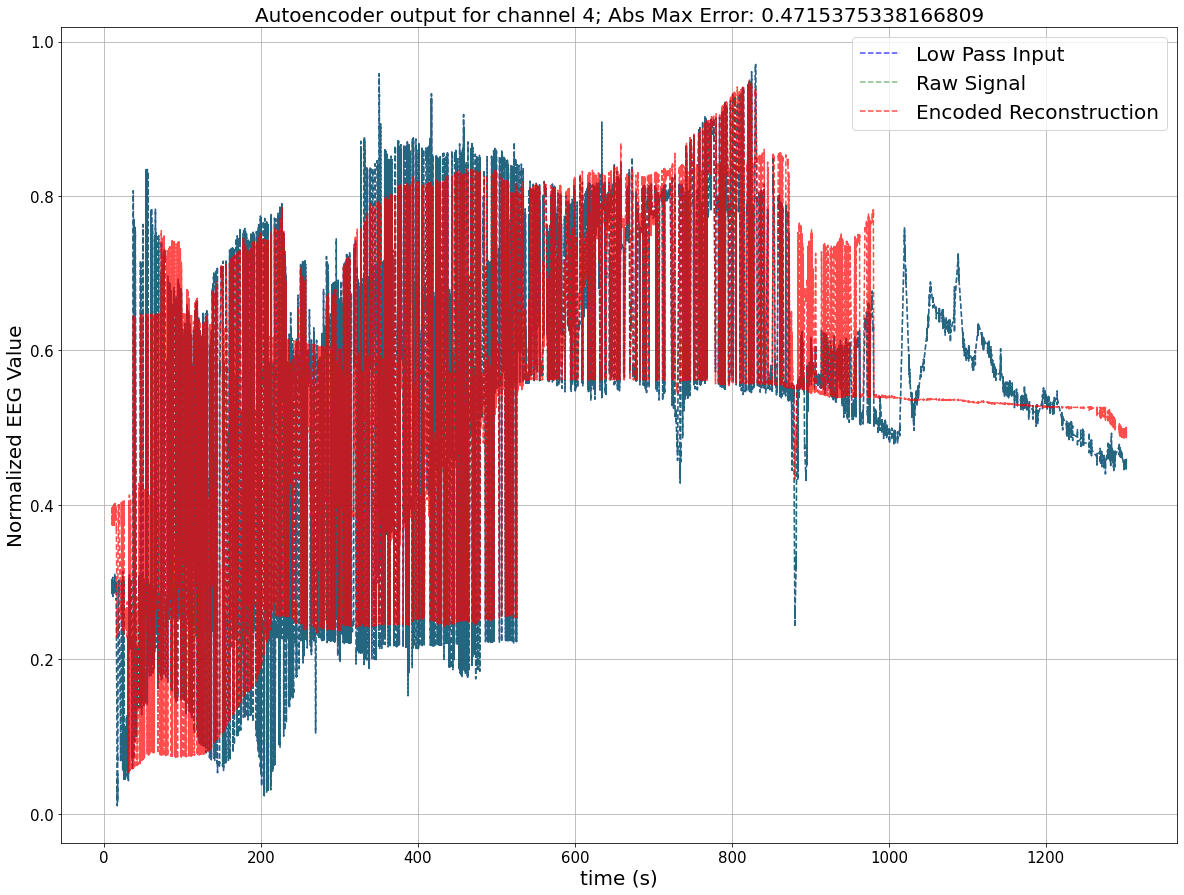

In [38]:
#encoder_model = autoencoder(num_features=num_features).cuda()
#encoder_model.load_state_dict(torch.load(model_path))

channel_errs = []

with torch.no_grad():
    encoder_model.eval()
    prev_shape = autoencoder_test.shape
    x = torch.from_numpy(autoencoder_test[:,:,2:]).float().reshape(-1,1,64).cuda() # eeg channels
    x_encoded = encoder_model(x).reshape(prev_shape[0], prev_shape[1], 64).detach().cpu().numpy().squeeze()
    
    print(f"Test MSE: {((autoencoder_test[:,:,2:] - x_encoded)**2).mean()}")
    
    for data_index in range(64):
        t = autoencoder_test[:, :, 0].flatten()
        ind_t = np.argsort(t)
        t = t[ind_t]
        z_raw = autoencoder_test_raw[:, :, data_index+2].flatten()[ind_t]
        z = autoencoder_test[:, :, data_index+2].flatten()[ind_t]
        z_hat = x_encoded[:, :, data_index].flatten()[ind_t]
        
        max_error = np.max(np.abs(z_hat - z))
        channel_errs.append(max_error)
        if data_index >= 5:
            continue
        fig, axs = plt.subplots(figsize=(20,15))
        axs.grid(True)
        axs.tick_params(axis='both', which='major', labelsize=15)
        axs.set_title(f"Autoencoder output for channel {data_index}; Abs Max Error: {max_error}", fontsize=20)
        axs.set_xlabel("time (s)", fontsize=20)
        axs.set_ylabel("Normalized EEG Value", fontsize=20)
        
        axs.plot(t, z, 'b--', alpha=0.7, label="Low Pass Input")
        axs.plot(t, z_raw, 'g--', alpha=0.5, label="Raw Signal")
        axs.plot(t, z_hat, 'r--', alpha=0.7, label='Encoded Reconstruction')
        
        
        axs.legend(loc='best', fontsize=20)
        plt.show()

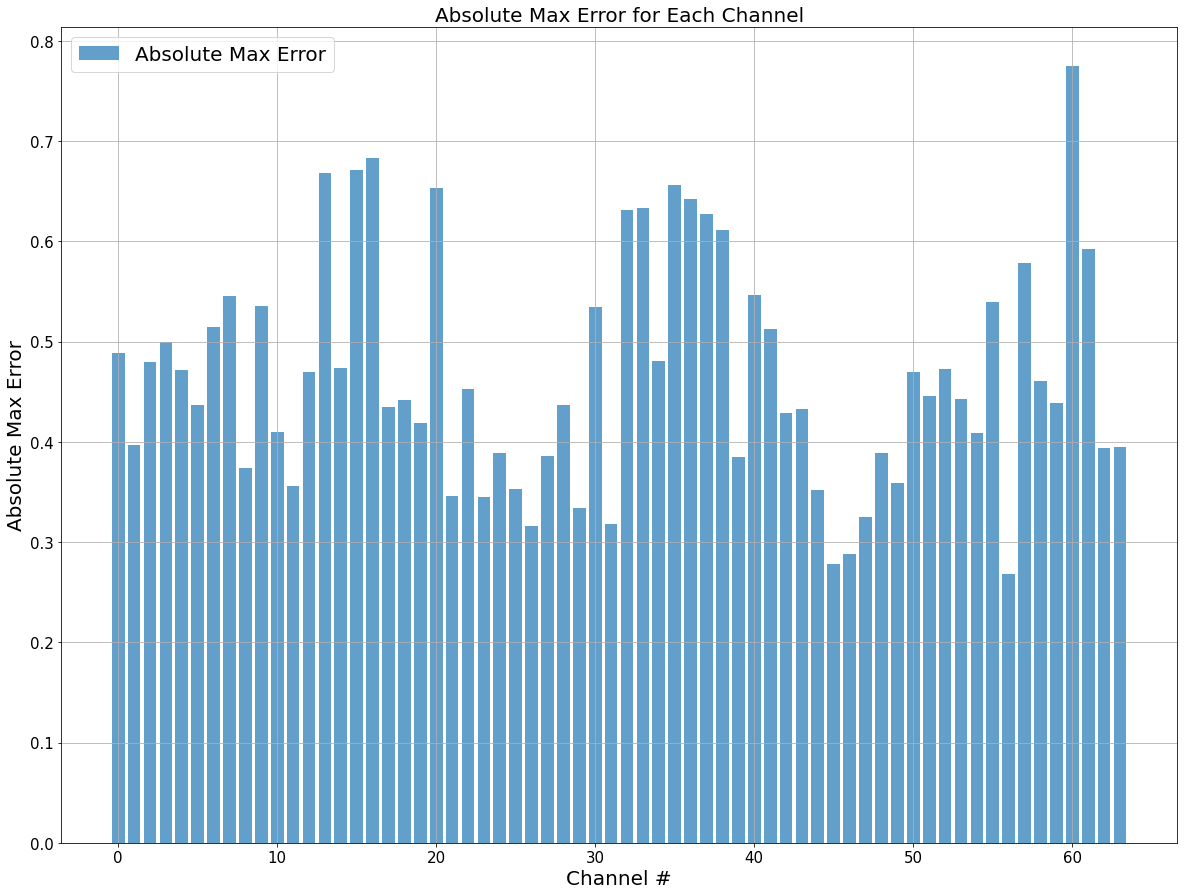

In [39]:
fig, axs = plt.subplots(figsize=(20,15))
axs.grid(True)
axs.tick_params(axis='both', which='major', labelsize=15)
axs.set_title(f"Absolute Max Error for Each Channel", fontsize=20)
axs.set_xlabel("Channel #", fontsize=20)
axs.set_ylabel("Absolute Max Error", fontsize=20)
axs.bar(np.arange(len(channel_errs)), channel_errs, alpha=0.7, label='Absolute Max Error')

axs.legend(loc='best', fontsize=20)
plt.show()